<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9 ;
           font-size:20px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">  
<center> <h1>🏡🏘 House Price Prediction 🏦🏠</h1> </center> 
</div>

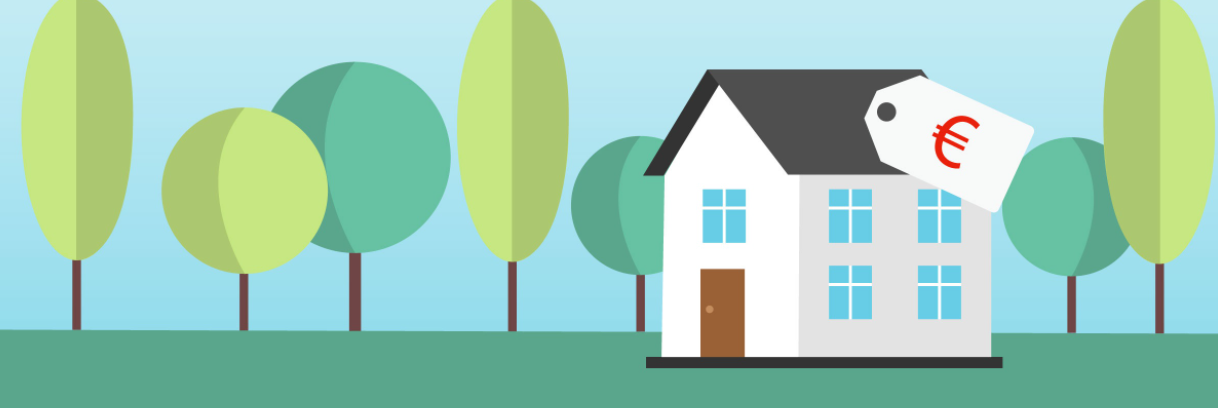

## Table of contents
* [1. Data Screening](#1.)
 - [1.1 Discret Columns](#1.1)
 - [1.2 Continuous Columns](#1.2)
 - [1.3 Visualizations](#1.3)
    - [1.3.1 Date Features](#1.3.1)
    - [1.3.2 Size Features](#1.3.2)
    - [1.3.3 Room Features](#1.3.3)
    - [1.3.4 Quality And Condition Features](#1.3.4)
    - [1.3.5 Material Features](#1.3.5)
    - [1.3.6 Other Categorical Features](#1.3.6)
    - [1.3.7 Other General Features](#1.3.7)
    - [1.3.8 General Plots](#1.3.8)
* [2. Data Preparation](#2.)
 - [2.1 Cleaning Functions](#2.1)
 - [2.2 Cleaning Functions Test](#2.2)
 - [2.3 Pipeline Functions](#2.3)
* [3. Simple Model](#3.)
 - [3.1 Fist Submission](#3.1)
* [4. Feature Engineering And Pipeline Extension](#4.)
 - [4.1 Test Additional Features And New Pipeline Functions](#4.1)
 - [4.2 New Pipeline](#4.2)
* [5. Modeling Selection And Parameter Tuning](#5.)
 - [5.1 Parameter Tuning With Optuna](#5.1)
     - [5.1.1 Optuna Stundy Visualisation For XGBRegressor](#5.1.1)
     - [5.1.2 Optuna Stundy Visualisation For GradientBoostingRegressor](#5.1.2)
     - [5.1.3 Model Performance Comparison](#5.1.3)
 - [5.2 New Submission](#5.2)
* [6. Tensorflow](#6.)
 - [6.1 Tensorflow Submission](#6.1)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
import warnings
from xgboost import plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedKFold, KFold, cross_val_score
from sklearn.preprocessing import QuantileTransformer
from IPython.display import display, HTML
import tensorflow as tf 
import math
warnings.filterwarnings(action='ignore', category=UserWarning) 

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">  
<center> <h2> 1. Data Screening 👀🔎📊</h2> </center>
    
<hr>
    
There are a lot of features, so let's create a DataFrame that contains the needed information about each column for later use.
</div>

In [ ]:
# loading data 
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv');
combined_df= pd.concat([train_df, test_df]);

In [ ]:
column_informations = {}
num_values = len(train_df)
for col in train_df.columns:
    num_unique = train_df[col].nunique()
    num_nulls = round(train_df[col].isna().sum()/num_values,2)
    d_type = train_df.dtypes[col]
    
    if (num_unique < 30):
        # discrete column
        info_str = "["
        value_counts = train_df[col].value_counts()
        single_value_weight = round(value_counts.iloc[0] / num_values, 2)
        for index, value in value_counts.items():
            info_str += f"{value} X {index}, "
        column_informations[col] = {"d_type":d_type, "discret": True, "percentage_of_missing_values": num_nulls, "single_value_weight": single_value_weight,
                                    "min": 0.0, "max": 0.0, "mean": 0.0, "median": 0.0, "info_str": info_str[:-2] + "]"} 
    else:
        # continuous column
        if d_type == "int64" or d_type == "float64":
            column_informations[col] = {"d_type":d_type, "discret": False, "percentage_of_missing_values": num_nulls, "single_value_weight": 0.0,
                                        "min": train_df[col].min(), "max": train_df[col].max(), "mean": round(train_df[col].mean(), 2),
                                        "median": round(train_df[col].median(), 2), "info_str": ""}
        else:
            column_informations[col] = {"d_type":d_type, "discret": False, "percentage_of_missing_values": num_nulls, "min": "-", "max": "-",
                                        "mean": "-", "median": "-", "info_str": ""}

# build DataFrame from dictionary
info_df = pd.DataFrame.from_dict(column_informations, orient='index')

<a id="1.1"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">  
<center>
<h3 id="1.1">
1.1 Discret Columns:
<a class="anchor-link" href="https://www.kaggle.com/stefanschulmeister87/visual-data-inspection-and-model-stacking-html-markdown/notebook#1.1">¶</a>
</h3>
<center>
</div>

In [ ]:
display(HTML(info_df[info_df["discret"]==True][["d_type", "percentage_of_missing_values", "single_value_weight", "info_str"]].to_html()))
print(len(info_df[info_df["discret"]==True]))

<a id="1.2"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left"> 
<center> <h3> 1.2 Continuous Columns</h3> </center>
</div>

In [ ]:
display(HTML(info_df[info_df["discret"]==False][["d_type", "percentage_of_missing_values", "min", "max", "mean", "median"]].to_html()))
print(len(info_df[info_df["discret"]==False]))

<a id="1.3"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">   
<center> <h3> 1.3 Visualizations: 📉📊📈</h3> </center>
</div>

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">  
<h4> So what do we have 🤔?</h4>
<hr>  
<ul>
  <li>We have 61 categorical features (i.e. they have a maximum of 30 different values).  </li>
  <li>We have 20 other (continues) features (with more than 30 different values). </li>
  <li>Some of these columns could also be interpreted as categorical. For example, GarageYrBlt, YearRemodAdd, or YearBuilt.</li>
  <li>A considerable number of categorical features have a single value weight of more than 80%, which means that more than 80% of all values are the same. </li>
  <li>We need to be careful with these. We may exclude them completely. </li>
  <li>Also, we have some features with many missing values. We will exclude those as well. </li>
  <li>Some continuous features have a median of 0 and the distance between min-max and mean may indicate a screwed distribution for some features. </li>
</ul>    
<hr>  
So, all in all, we have a lot of different features that may or may not contain valuable information about the selling price. So let's divide these features into different groups for some visualizations to get a better understanding of the whole data structure.
But first let's look at the distribution of the label itself.
</div>

In [ ]:
"""
Let's start with a general colour setting for seaborn. (We only have to do this once and all the plots in this notebook will have the same look!) 
"""
sns.set(rc={'axes.facecolor':"#F1FFC9",
            "figure.facecolor":"#B2C679",
            "grid.color":"#E0D3AF",
            "axes.edgecolor":"#505541",
            "axes.labelcolor":"#505541",
            "text.color":"#505541"
           }) 
# change axes lebelsize. (We change the tick size for each plot separately depending on its size.)
sns.set_context(rc={"axes.labelsize" : 20})

In [ ]:
f, ax = plt.subplots(figsize=(25, 7))
ax.tick_params(labelsize=15)
sns.histplot(data = train_df,x="SalePrice", kde=True, bins=200).set_title('SalePrice Distribution', fontdict= {'fontsize': 24});

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">  
As we can see, the distribution of our table is clearly left skewed. Most of the time, regression models will perform better if the distribution of the target is normally distributed. So let's use the quantile transformer for Sklearn to achieve this for our target.
</div>   

In [ ]:
"""
Using quantile tranformer for transforming 
"""
qt = QuantileTransformer(random_state=0, output_distribution="normal")
target = train_df["SalePrice"].copy()
target = target.values.reshape(-1, 1)
target = qt.fit_transform(target)
target_df=pd.DataFrame(target).rename(columns={0: "Transformed_SalePrice"})

In [ ]:
"""
That was relatively straightforward. Let's take a look at our transformed target.
"""
f, ax = plt.subplots(figsize=(25, 7))
ax.tick_params(labelsize=15)
sns.histplot(data = target_df,x="Transformed_SalePrice", kde=True, bins=200).set_title('Transformed SalePrice Distribution', fontdict= {'fontsize': 24});

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">  
This looks very mouch normally distributed. We have to bear in mind that we will have to retransform our predictions later, if we transform our target befor training.
For further visualisations it will be useful to group these prices into manageable units of equal number. We will use the "old" SalePrices for our visual groups.
</div>   

In [ ]:
number_of_price_groups = 5
number_of_values_per_group = len(train_df)/number_of_price_groups

visual_df = train_df.copy()
visual_df.sort_values(by=['SalePrice'], inplace=True, ignore_index=True)

"""
Get group ranges (we want the same amount of members in each group)
"""
last_boundary = 0
bounder_dict={}
for i in range(number_of_price_groups):
    boundary = visual_df.iloc[int((i+1)*number_of_values_per_group) - 1]["SalePrice"]
    bounder_dict[f"{last_boundary}-{boundary}"] = [last_boundary, boundary]
    last_boundary = boundary

def get_price_group(price, bounder_dict):
    group_lable = "-"
    for group in bounder_dict.keys():
        if bounder_dict[group][0] < price <= bounder_dict[group][1]:
            group_lable=group
    return group_lable
    
visual_df["PriceGroup"]=visual_df["SalePrice"].map(lambda x: get_price_group(x, bounder_dict));

In [ ]:
"""
Let's check:
"""
indexs =[]
for group in visual_df["PriceGroup"].unique():
    indexs.append(visual_df[["SalePrice", "PriceGroup"]][visual_df["PriceGroup"]==group].head(1).index[0])
visual_df.loc[indexs][["SalePrice", "PriceGroup"]]

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">  
Looks good. No "-" and all groups seem to work fine. So let's continue with some plots of the date features with our new price groups and see if we find something.
</div>

<a id="1.3.1"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">  
<center> <h3> 1.3.1 Date Features: 🔦📆</h3> </center>
<hr>
<h4>Features Explanation:</h4>
<ul>
<li> YrSold: Year Sold (YYYY) </li> 
<li> MoSold: Month Sold (MM) </li>
<li> GarageYrBlt: Year garage was built </li>
<li> YearBuilt: Original construction date </li>
<li> YearRemodAdd: Remodel date (same as construction date if no remodeling or additions) </li>
</ul>
</div>

In [ ]:
data_features = ["YearBuilt", "YearRemodAdd", "GarageYrBlt", "MoSold", "YrSold"]
info_df.loc[data_features]

In [ ]:
"""
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Note: The code for these subplots will be fairly repetitive, so I will exclude them in most cases. 
If you have any questions about the plots, you can feel free to ask me in the comments section.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
"""

# build figure
fig = plt.figure(figsize=(25,7))

# add grid to figure 
gs = fig.add_gridspec(1,5)

# fill grid with subplots
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax02 = fig.add_subplot(gs[0,2])
ax03 = fig.add_subplot(gs[0,3])
ax04 = fig.add_subplot(gs[0,4])

# adjust subheadline fontsize
ax00.set_title('Year Built', fontsize=20)
ax01.set_title('Year Remod Added', fontsize=20)
ax02.set_title('Garage Year Built', fontsize=20)
ax03.set_title('Month Sold', fontsize=20)
ax04.set_title('Year Sold', fontsize=20)

# adjust lable fontsize
ax00.tick_params(labelsize=12)
ax01.tick_params(labelsize=12)
ax02.tick_params(labelsize=12)
ax03.tick_params(labelsize=12)
ax04.tick_params(labelsize=12)

# plot (ax=axxx is important)
sns.histplot(data = visual_df,x="YearBuilt", kde=False, ax=ax00, bins=25, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data = visual_df,x="YearRemodAdd", kde=False, ax=ax01, bins=25, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data = visual_df,x="GarageYrBlt", kde=False, ax=ax02, bins=25, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data = visual_df,x="MoSold", kde=False, ax=ax03, bins=25, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data = visual_df,x="YrSold", kde=True, ax=ax04, bins=25, palette="Set2", multiple="stack", hue="PriceGroup");

# add headline: (subplots_adjust must be adjusted if you change the gridspec height. So if you have more than one row of plots).
fig.subplots_adjust(top=0.8)
fig.suptitle('Date Features vs PriceGroup', fontsize="28");

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">  
Contrary to my expectation, we see no correlation between YrSold and PriceGroup. YearBuilt, YearRemodAdd and GarageYrBlt have the expected impact on PriceGroup. There are no surprises here.

<h4> But what about the significant number of building with YearRemodAdd in 1950 ❔ </h4> 
</div>

In [ ]:
fig = plt.figure(figsize=(25,5))
gs = fig.add_gridspec(1,2)
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax00.tick_params(axis='both', which='major', labelsize=15)
ax01.tick_params(axis='both', which='major', labelsize=15)
ax00.set_title('Buildings with RemodAdd in 1950', fontsize=20)
ax01.set_title('Buildings build bevore 1950 and RemoveAdd not in 1950', fontsize=20)
sns.histplot(data=visual_df[visual_df["YearRemodAdd"]==1950.0], x="YearBuilt", ax=ax00, bins=55, color="g")
sns.histplot(data=visual_df[(visual_df["YearBuilt"]<=1950.0) & (visual_df["YearRemodAdd"]!=1950.0)], x="YearBuilt", ax=ax01, bins=55);

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left"> 
Ok, most of the buildings built before 1950 were built after 1900 and given the history between 1914 and 1945 it seems understandable that none of them were remodeled before 1950. It still seems a little odd that so many were renovated in that year and not in 1949 for example. Perhaps there was some sort of government assistance? Bevore we move on let's look at the distribution of time between YearBuild and RemoveAdd and the time between RemovedAdd and YrSold.
</div>

In [ ]:
visual_df["YearsSinceRemode"] = visual_df["YrSold"] - visual_df["YearRemodAdd"]
visual_df["YearsUntilRemode"] = visual_df["YearRemodAdd"] - visual_df["YearBuilt"]

In [ ]:
fig = plt.figure(figsize=(25,5))
gs = fig.add_gridspec(1,2)
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax00.tick_params(axis='both', which='major', labelsize=15)
ax01.tick_params(axis='both', which='major', labelsize=15)
ax00.set_title('YearsSinceRemode', fontsize=20)
ax01.set_title('YearsUntilRemode', fontsize=20)
sns.histplot(data=visual_df, x="YearsSinceRemode", kde=False, ax=ax00, bins=55, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data=visual_df, x="YearsUntilRemode", kde=False, ax=ax01, bins=55, palette="Set2", multiple="stack", hue="PriceGroup");

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left"> 
It looks like very few buildings have been reworked. Of course, this makes the feature much less interesting. Too bad. It looks like very few buildings have been reworked. Of course, this makes the feature much less interesting. Too bad. Moreover, our new YearsSinceRemode feature is almost the same as the past time since construction. We will use one of the features later. Let's close this subsection by looking at the correlation between all these date features. We should see a strong correlation between YearBuilt, YearRemodAdd and GarageYrBlt.
</div>   

In [ ]:
corr = visual_df[data_features + ["SalePrice", "YearsSinceRemode", "YearsUntilRemode"]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(15, 15))
ax.tick_params(axis='both', which='major', labelsize=15)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, square=True, linewidths=1, linecolor="black", annot=True, 
                cbar_kws={"shrink": 0.6}).set_title('Pairwise correlations of continuous columns', fontsize="28");

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left"> 
As expectet we see the significant correlation between GarageYrBlt, YearBuit and YearRemodeAdd. The correlation between GarageYrBlt and YearRemodAdd is also not surprising. It is interesting to note that all three characteristics have more or less the same correlation with SalePrice. 
The correlation between YearsSinceRemode and YearRemodAdd is also obvious, but including this feature could make the algorithm's job easier.
</div>

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left"> 

<h4> Conclusion: 📝</h4>
<hr>
<ul>  
<li> We have 5 different date features and we could craft some more, but the included information is nearly the same. </li>
  <ul>
  <li> The resaon for that is, that YearRemodAdd and YearBuild are the some most of the time. </li>
  <li> The same holds for YearBuilt and GarageYrBlt </li>
  </ul>
<li> We will decide later which ones to use. </li>
</ul> 
Let us now turn to the characteristics describing the size of the different parts of the building.
</div>

<a id="1.3.2"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left"> 
<center> <h3> 🛵🏘 1.3.2 Size Features: 🚙🏦 </h3> </center>
    <hr>
    <h4> Features Explanation: </h4>
<ul>
<li> General areas: </li>
    <ul>
    <li> WoodDeckSF: Wood deck area in square feet </li>
    <li> OpenPorchSF: Open porch area in square feet </li>
    <li> EnclosedPorch: Enclosed porch area in square feet </li>
    <li> 3SsnPorch: Three season porch area in square feet </li>
    <li> ScreenPorch: Screen porch area in square feet </li>
    <li> LotArea:      Lot size in square feet </li>
    <li> MasVnrArea:   Masonry veneer area in square feet </li>
    <li> GarageArea:   Size of garage in square feet </li>
    <li> GarageCars: Size of garage in car capacity </li>
    </ul>
<li> Basement areas: </li>
    <ul>
    <li> BsmtFinSF1:   Type 1 finished basement in square feet </li>
    <li> BsmtFinSF2:   Type 2 finished basement in square feet </li>
    <li> BsmtUnfSF:    Unfinished square feet of basement area </li>
    <li> TotalBsmtSF:  Total square feet of basement area </li>
    </ul>
<li> Living areas: </li>
    <ul>
    <li> 1stFlrSF:     First Floor square feet </li>
    <li> 2ndFlrSF:     Second floor square feet </li>
    <li> LowQualFinSF: Low quality finished square feet (all floors) </li>
    <li> GrLivArea:    Above grade (ground) living area square feet </li>
    </ul>
</ul>
We will remove "WoodDeckSF", "OpenPorchSF", "LowQualFinSF", "PoolArea", "BsmtFinSF2", "EnclosedPorch", "3SsnPorch" and "ScreenPorch" for now. (most values are 0)

In [ ]:
size_features = ["LotArea","BsmtFinSF1", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GrLivArea", "GarageArea", "MasVnrArea", "OpenPorchSF"]
info_df.loc[size_features]

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left"> 
From the distance between min, max, medina, and mean, we can tell that most of these features contain outliers. We will exclude them for the visualizations.
</div>

In [ ]:
"""
Exclude outliers (top and bottom 10%)
"""
for feature in size_features:
    upper_quantile = visual_df[feature].quantile(0.9)
    lower_quantile = visual_df[feature].quantile(0.1)
    visual_df[feature] = np.where(visual_df[feature]>upper_quantile, upper_quantile,visual_df[feature])
    visual_df[feature] = np.where(visual_df[feature]<lower_quantile, lower_quantile,visual_df[feature])

In [ ]:
fig = plt.figure(figsize=(25,15))
gs = fig.add_gridspec(2,2)
ax0 = fig.add_subplot(gs[0,:])
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax0.set_title('Area Features ex LotArea', fontsize=20)
ax10.set_title('LotArea vs PriceGroup', fontsize=20)
ax11.set_title('GarageCars vs PriceGroup', fontsize=20)
ax0.tick_params(labelsize=15)
ax10.tick_params(labelsize=12)
ax11.tick_params(labelsize=15)
sns.violinplot(data=visual_df[size_features[1:]], inner="quart", linewidth=1, ax=ax0, scale="width")
sns.violinplot(data=visual_df, y=size_features[0], x="PriceGroup", inner="quart", linewidth=1, ax=ax10, scale="width", palette="pastel");
sns.histplot(visual_df, x="GarageCars", hue="PriceGroup", bins=15, multiple="stack",ax=ax11, palette="pastel", kde=False, linewidth=2);

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left"> 
GarageCars looks promesing but do we need this feature when we have GarageArea?

In [ ]:
f, ax = plt.subplots(figsize=(25, 5))
ax.tick_params(labelsize=15)
sns.scatterplot(data=visual_df, x="GarageArea", y="GarageCars", sizes=(50, 500), palette="Paired")
f.subplots_adjust(top=0.9)
f.suptitle('GarageCars vs GarageArea', fontsize="28");

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left"> 
    <h4> Conclusion: 📝 </h4>
<hr>
<ul>
<li> BsmtFinSF1, 2ndFlrSF and MasVnrArea and all excluded size features are mostly 0, because those areas are not included in all buildings.</li>
    <ul>
    <li> We may exclude them and create some features that indicate whether certain areas are included or not. </li>
    </ul>
<li> We should keep either GaraeArea or GarageCase, not both. Maybe GarageCars is the better choice, since it is not so prone to overfitting. </li>
<li> All these outliers will disturb our algorithms, so we should exclude them for training. </li>
</ul>

Let's move on to room features.
</div>

<a id="1.3.3"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left"> 
<center> <h3> 1.3.3 Room Features: 🛏🚽🍳</h3> </center>
<hr>
<h4>Features Explanation: </h4>
<ul>
<li> BsmtFullBath: Basement full bathrooms </li>
<li> BsmtHalfBath: Basement half bathrooms </li>
<li> FullBath: Full bathrooms above grade </li>
<li> HalfBath: Half baths above grade </li>
<li> BedroomAbvGr: Bedrooms above grade (does NOT include basement bedrooms) </li>
<li> KitchenAbvGr: Kitchens above grade </li> 
<li> TotRmsAbvGrd: Total rooms above grade (does not include bathrooms) </li>
</ul>

In [ ]:
room_features= ["BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd"]
info_df.loc[room_features]

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left"> 
Let's start by creating a feature for the total number of rooms (TotRms) and see how it correlates with our PriceGroups compared to the existing feature TotRmsAbvGrd.
</div>

In [ ]:
"""
Build total number of rooms feature:
"""
visual_df["TotRms"] = visual_df["TotRmsAbvGrd"] + visual_df["FullBath"] + visual_df["HalfBath"] + visual_df["BsmtFullBath"] + visual_df["BsmtHalfBath"] + visual_df["BedroomAbvGr"] + visual_df["KitchenAbvGr"]

fig = plt.figure(figsize=(25,5))
gs = fig.add_gridspec(1,2)
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax00.tick_params(labelsize=15)
ax01.tick_params(labelsize=15)
sns.histplot(visual_df, x="TotRms", hue="PriceGroup", bins=15, multiple="stack",ax=ax00, palette="pastel", linewidth=2).set_title('Total number of Rooms vs PriceGroup', fontdict= {'fontsize': 24})
sns.histplot(visual_df, x="TotRmsAbvGrd", hue="PriceGroup", bins=15, multiple="stack",ax=ax01, palette="pastel", linewidth=2).set_title('TotRmsAbvGrd vs PriceGroup', fontdict= {'fontsize': 24});

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left"> 
As expected. Buildings with more rooms are more expensive and vice versa. We could take a closer look at basements and living spaces. We can see that the single value weight of so some of these features are quite hight. So they may not be so interesting alone.
Let's take a quick look at the distribution.
</div>

In [ ]:
room_features= ["BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd"]
fig = plt.figure(figsize=(25,12))
gs = fig.add_gridspec(2,3)
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax02 = fig.add_subplot(gs[0,2])
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax12 = fig.add_subplot(gs[1,2])
ax00.set_title('BsmtFullBath', fontsize=20)
ax01.set_title('BsmtHalfBath', fontsize=20)
ax02.set_title('FullBath', fontsize=20)
ax10.set_title('HalfBath', fontsize=20)
ax11.set_title('BedroomAbvGr', fontsize=20)
ax12.set_title('KitchenAbvGr', fontsize=20)
ax00.tick_params(labelsize=15)
ax01.tick_params(labelsize=15)
ax02.tick_params(labelsize=15)
ax10.tick_params(labelsize=15)
ax11.tick_params(labelsize=15)
ax12.tick_params(labelsize=15)
"""
We remove the xlabel sinze they are clear from the subplot headline.
"""
sns.histplot(visual_df, x="BsmtFullBath", hue="PriceGroup", bins=15, multiple="stack", ax=ax00, palette="pastel", kde=False, linewidth=2).set(xlabel=None)
sns.histplot(visual_df, x="BsmtHalfBath", hue="PriceGroup", bins=15, multiple="stack",ax=ax01, palette="pastel", kde=False, linewidth=2).set(xlabel=None)
sns.histplot(visual_df, x="FullBath", hue="PriceGroup", bins=15, multiple="stack",ax=ax02, palette="pastel", kde=False, linewidth=2).set(xlabel=None)
sns.histplot(visual_df, x="HalfBath", hue="PriceGroup", bins=15, multiple="stack",ax=ax10, palette="pastel", kde=False, linewidth=2).set(xlabel=None)
sns.histplot(visual_df, x="BedroomAbvGr", hue="PriceGroup", bins=15, multiple="stack",ax=ax11, palette="pastel", kde=False, linewidth=2).set(xlabel=None)
sns.histplot(visual_df, x="KitchenAbvGr", hue="PriceGroup", bins=15, multiple="stack",ax=ax12, palette="pastel", kde=False, linewidth=2).set(xlabel=None)     
fig.subplots_adjust(top=0.9)
fig.suptitle('Number of Rooms vs PriceGroup', fontsize="28");

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left"> 
<h4> Conclusion: 📝 </h4>
<hr>
<ul>    
<li> As with the date characteristics, we have a wide variety of expressions for these characteristics, but the information content of the individual expressions seems to be quite low. </li>
<li> We will also create one or two characteristics from combinations of these in the further course and not use all of them. </li>
</ul>
Let's continue with quality and condition features.
</div>

<a id="1.3.4"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left"> 
    
<center> <h4> 1.3.4 Quality And Conditon Features: </h4> </center>
<hr>
<h4> Features Explanation: </h4>
<ul>
<li> OverallQual: Rates the overall material and finish of the house </li>
<li> OverallCond: Rates the overall condition of the house </li> 
<li> ExterQual: Evaluates the quality of the material on the exterior </li>
<li> ExterCond: Evaluates the present condition of the material on the exterior </li>
<li> BsmtQual: Evaluates the height of the basement </li>
<li> BsmtCond: Evaluates the general condition of the basement </li>
<li> BsmtFinType1: Rating of basement finished area </li>
<li> BsmtFinType2: Rating of basement finished area (if multiple types) </li>
<li> KitchenQual: Kitchen quality </li>
<li> FireplaceQu: Fireplace quality </li>
<li> GarageQual: Garage quality </li>
<li> GarageCond: Garage condition </li>
<li> PoolQC: Pool quality </li>
<li> Fence: Fence quality </li>
</ul>
Let's take a look at these features.
</div>

In [ ]:
qual_and_con_features = ["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtFinType1", "BsmtFinType2", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC", "Fence", "HeatingQC"]
info_df.loc[qual_and_con_features][["discret", "percentage_of_missing_values", "single_value_weight", "info_str"]]

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left"> 
We will exclude all features with more then 60% single value weight und more then 80% missing values.
</div>

In [ ]:
clean_qual_and_con_features = [f for f in qual_and_con_features if info_df.loc[f]["percentage_of_missing_values"] < 0.6 
                               and info_df.loc[f]["single_value_weight"] < 0.8]
print("Remaining quality and condition features:")
clean_qual_and_con_features

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left"> 
Let's take a closer look at these features.
</div>

In [ ]:
# build figure
fig = plt.figure(figsize=(25,18))

# add grid to figure
gs = fig.add_gridspec(3,3)

# fill grid with subplots
ax0001 = fig.add_subplot(gs[0,0:2])
ax02 = fig.add_subplot(gs[0, 2])
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax12 = fig.add_subplot(gs[1,2])
ax20 = fig.add_subplot(gs[2,0])
ax21 = fig.add_subplot(gs[2,1])
ax22 = fig.add_subplot(gs[2,2])

# adjust subheadline fontsize
ax0001.set_title('OverallQual', fontsize=20)
ax02.set_title('OverallCond', fontsize=20)
ax10.set_title('HeatingQC', fontsize=20)
ax11.set_title('ExterQual', fontsize=20)
ax12.set_title('BsmtQual', fontsize=20)
ax20.set_title('BsmtFinType1', fontsize=20)
ax21.set_title('KitchenQual', fontsize=20)
ax22.set_title('FireplaceQu', fontsize=20)

# adjust lable fontsize
ax0001.tick_params(labelsize=12)
ax02.tick_params(labelsize=12)
ax10.tick_params(labelsize=12)
ax11.tick_params(labelsize=12)
ax12.tick_params(labelsize=12)
ax20.tick_params(labelsize=12)
ax21.tick_params(labelsize=12)
ax22.tick_params(labelsize=12)

sns.histplot(data = visual_df,x="SalePrice", kde=False, ax =ax0001, bins=50, hue="OverallQual", palette="Set2", multiple="stack").set(xlabel=None)  
sns.histplot(data = visual_df,x="SalePrice", kde=False, ax =ax02, bins=25, hue="OverallCond", palette="Set2", multiple="stack").set(xlabel=None)  
sns.histplot(data = visual_df,x="SalePrice", kde=False, ax =ax10, bins=25, hue="HeatingQC", palette="Set2", multiple="stack").set(xlabel=None)  
sns.histplot(data = visual_df,x="SalePrice", kde=False, ax =ax11, bins=25, hue="ExterQual", palette="Set2", multiple="stack").set(xlabel=None)  
sns.histplot(data = visual_df,x="SalePrice", kde=False, ax =ax12, bins=25, hue="BsmtQual", palette="Set2", multiple="stack").set(xlabel=None)  
sns.histplot(data = visual_df,x="SalePrice", kde=False, ax =ax20, bins=25, hue="BsmtFinType1", palette="Set2", multiple="stack").set(xlabel=None)  
sns.histplot(data = visual_df,x="SalePrice", kde=False, ax =ax21, bins=25, hue="KitchenQual", palette="Set2", multiple="stack").set(xlabel=None)  
sns.histplot(data = visual_df,x="SalePrice", kde=False, ax =ax22, bins=25, hue="FireplaceQu", palette="Set2", multiple="stack").set(xlabel=None)  

# add headline
fig.subplots_adjust(top=0.92)
fig.suptitle('Quality and condition features vs SalePrice', fontsize="28");

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left"> 
<h4>Conclusion: 📝</h4>
<hr>
<ul>
<li> OverallQual seems to be the most important of these features. </li>
<li> ExterQual, BsmtQual and KitchenQual look very similar. </li>
<li> OverallCond looks counter intuitive. Maybe the way this feature is determined is not so standardized. </li>
<ul>
</div>

<a id="1.3.5"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left"> 
    
<center> <h4> 1.3.5 Material Features: </h4> </center>
<hr>
    
<h4> Features Explanation: </h4>
<ul>
<li>  RoofMatl: Roof material </li> 
<li>  Exterior1st: Exterior covering on house </li>
<li>  Exterior2nd: Exterior covering on house (if more than one material) </li>
<li>  MasVnrType: Masonry veneer type </li>
<li>  Foundation: Type of foundation </li>
<li>  PavedDrive: Paved driveway </li>
<li>  GarageFinish: Interior finish of the garage </li>
</ul>
</div>

In [ ]:
material_features = ["RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "PavedDrive", "BsmtFinType1", "GarageFinish"]
info_df.loc[material_features][["discret", "percentage_of_missing_values", "single_value_weight", "info_str"]]

In [ ]:
"""
We exclude RoofMatl and PavedDrive due to there single value weight.
"""
clean_material_features = ["Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "BsmtFinType1", "GarageFinish"]
print("Remaining material features:")
clean_material_features

<a id="1.3.5"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
Let's see how they are distributed and what is their correlation with the selling price.
</div>

In [ ]:
# build figure
fig = plt.figure(figsize=(25,18))

# add grid to figure
gs = fig.add_gridspec(3,2)

# fill grid with subplots
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax20 = fig.add_subplot(gs[2,0])
ax21 = fig.add_subplot(gs[2,1])

# adjust subheadline fontsize
ax00.set_title('MasVnrType', fontsize=20)
ax01.set_title('GarageFinish', fontsize=20)
ax10.set_title('Exterior1st', fontsize=20)
ax11.set_title('Exterior2nd', fontsize=20)
ax20.set_title('Foundation', fontsize=20)
ax21.set_title('BsmtFinType1', fontsize=20)

# adjust lable fontsize
ax00.tick_params(labelsize=15)
ax01.tick_params(labelsize=15)
ax10.tick_params(labelsize=15)
ax11.tick_params(labelsize=15)
ax12.tick_params(labelsize=15)
ax20.tick_params(labelsize=15)
ax21.tick_params(labelsize=15)
ax22.tick_params(labelsize=15)

sns.histplot(data = visual_df,x="SalePrice", kde=False, ax =ax00, bins=75, hue="MasVnrType", palette="Paired", multiple="stack").set(xlabel=None)  
sns.histplot(data = visual_df,x="SalePrice", kde=False, ax =ax01, bins=75, hue="GarageFinish", palette="Paired", multiple="stack").set(xlabel=None)  
sns.histplot(data = visual_df,x="SalePrice", kde=False, ax =ax10, bins=25, hue="Exterior1st", palette="Paired", multiple="stack").set(xlabel=None)  
sns.histplot(data = visual_df,x="SalePrice", kde=False, ax =ax11, bins=25, hue="Exterior2nd", palette="Paired", multiple="stack").set(xlabel=None)  
sns.histplot(data = visual_df,x="SalePrice", kde=False, ax =ax20, bins=25, hue="Foundation", palette="Paired", multiple="stack").set(xlabel=None)  
sns.histplot(data = visual_df,x="SalePrice", kde=False, ax =ax21, bins=25, hue="BsmtFinType1", palette="Paired", multiple="stack").set(xlabel=None)  

# add headline
fig.subplots_adjust(top=0.92)
fig.suptitle('Quality and condition feature vs PriceGroup', fontsize="28");

<a id="1.3.5"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<h4>Conclusion: 📝</h4>
<hr>
    
* This looks interesting. Especially Exterior1st, Exterior2nd, BsmtFinType1 and GarageFinish. 
* MasVnrType could be excluded for training.

<a id="1.3.6"></a>

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<center> <h4> 1.3.6 Other Categorical Features: </h4> </center>
<hr>
<h4> Features Explanation: </h4>   
<ul>
<li> MSSubClass: Identifies the type of dwelling involved in the sale. </li>
<li> MSZoning: Identifies the general zoning classification of the sale. </li> 
<li> LotShape: General shape of property </li>
<li> LandContour: Flatness of the property </li>
<li> Utilities: Type of utilities available </li>
<li> LotConfig: Lot configuration </li>
<li> LandSlope: Slope of property </li>
<li> Neighborhood: Physical locations within Ames city limits </li>
<li> BldgType: Type of dwelling </li>
<li> HouseStyle: Style of dwelling </li>
<li> RoofStyle: Type of roof </li>
<li> Heating: Type of heating </li>
<li> Electrical: Electrical system </li>
<li> Functional: Home functionality (Assume typical unless deductions are warranted) </li>
<li> GarageType: Garage location </li>
<li> MiscFeature: Miscellaneous feature not covered in other categories </li>
<li> SaleCondition: Condition of sale </li>
<li> PavedDrive: Paved driveway </li>
<li> CentralAir: Central air conditioning </li>
</ul>
</div>

In [ ]:
other_categorical_features = ["MSSubClass", "MSZoning", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", "Neighborhood", "BldgType", "HouseStyle", "RoofStyle", "Heating", "Electrical", "Functional", "GarageType", "MiscFeature", "SaleCondition", "PavedDrive", "CentralAir"]
info_df.loc[other_categorical_features][["discret", "percentage_of_missing_values", "single_value_weight", "info_str"]]

In [ ]:
"""
Again we will exclude all features with more then 80% single value weight und more then 60% missing values.
"""
clean_other_categorical_features = [f for f in other_categorical_features if info_df.loc[f]["percentage_of_missing_values"] < 0.6 
                               and info_df.loc[f]["single_value_weight"] < 0.8]
print("Remaining other categorical features:")
clean_other_categorical_features

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
  
<h4> What about the correlation to our PriceGroup feature 🤔?</h4>
</div>

In [ ]:
# build figure
fig = plt.figure(figsize=(25,25))

# add grid to figure
gs = fig.add_gridspec(3,3)

# fill grid with subplots
ax0001 = fig.add_subplot(gs[0,0:2])
ax02 = fig.add_subplot(gs[0,2])
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax12 = fig.add_subplot(gs[1,2])
ax20 = fig.add_subplot(gs[2,0])
ax21 = fig.add_subplot(gs[2,1])
ax22 = fig.add_subplot(gs[2,2])

# adjust subheadline fontsize
ax0001.set_title('Neighborhood', fontsize=20)
ax02.set_title('LotShape', fontsize=20)
ax10.set_title('LotConfig', fontsize=20)
ax11.set_title('MSSubClass', fontsize=20)
ax12.set_title('HouseStyle', fontsize=20)
ax20.set_title('RoofStyle', fontsize=20)
ax21.set_title('GarageType', fontsize=20)
ax22.set_title('MSZoning', fontsize=20)

# adjust lable fontsize
ax0001.tick_params(labelsize=15)
ax02.tick_params(labelsize=15)
ax10.tick_params(labelsize=15)
ax11.tick_params(labelsize=15)
ax12.tick_params(labelsize=15)
ax20.tick_params(labelsize=15)
ax21.tick_params(labelsize=10)
ax22.tick_params(labelsize=15)

sns.histplot(data = visual_df,y="Neighborhood", kde=False, ax=ax0001, bins=50, hue="PriceGroup", palette="Set2", multiple="stack", linewidth=2)
sns.histplot(data = visual_df,y="LotShape", kde=False, ax=ax02, bins=25, hue="PriceGroup", palette="Set2", multiple="stack", linewidth=2)
sns.histplot(data = visual_df,y="LotConfig", kde=False, ax=ax10, bins=25, hue="PriceGroup", palette="Set2", multiple="stack", linewidth=2)
sns.histplot(data = visual_df,y="MSSubClass", kde=False, ax=ax11, bins=25, hue="PriceGroup", palette="Set2", multiple="stack", linewidth=2)
sns.histplot(data = visual_df,y="HouseStyle", kde=False, ax=ax12, bins=25, hue="PriceGroup", palette="Set2", multiple="stack", linewidth=2)
sns.histplot(data = visual_df,y="RoofStyle", kde=False, ax=ax20, bins=25, hue="PriceGroup", palette="Set2", multiple="stack", linewidth=2)
sns.histplot(data = visual_df,x="SalePrice", kde=False, ax=ax21, bins=25, hue="GarageType", palette="Set2", multiple="stack", linewidth=2)
sns.histplot(data = visual_df,y="MSZoning", kde=False, ax=ax22, bins=25, hue="PriceGroup", palette="Set2", multiple="stack", linewidth=2)
# add headline
fig.subplots_adjust(top=0.94)
fig.suptitle('Categorical Features vs PriceGroup', fontsize="28");

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<h4> Conclusion: 📝</h4>
<hr>
<ul>  
<li> As expected, the neighborhood appears to be significant. </li>
<li> LotConfig, RoofStyle and MSZoning have a very high single value weight and the other properties contain little information. We could exclude them or convert them to binary features like HasHipRoof or RMZonig. </li>
<li> GarageType looks interesting. We should convert this feature to a binary feature. Maybe AttachedGarage. </li>
<li> The same goes for Lot Shape and HouseStyle. Here we could add something like RegularShape (Yes/No) and HouseStyle -> (1Story, 2Story, other). </li>
<li> I think we can exclude MSSubClass. We can see some strong price correlations, e.g. in group 30, but I think the size of the single group is too small and could easily lead to overfitting.</li> 
</ul> 

<a id="1.3.7"></a>

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<center> <h4> 1.3.7 Other General Features: </h4> </center>
<hr>
    
<h4> Features Explanation: </h4>
<ul>   
<li> LotFrontage: Linear feet of street connected to property </li>
<li> BsmtExposure: Walkout or garden level basement walls </li>
<li> Fireplaces: Number of fireplaces </li>
<li> EnclosedPorch: Enclosed porch area in square feet </li>
</ul>

In [ ]:
other_general_features = ["LotFrontage", "BsmtExposure", "Fireplaces", "EnclosedPorch"]
info_df.loc[other_general_features]

In [ ]:
fig = plt.figure(figsize=(25,7))
gs = fig.add_gridspec(1,4)
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax02 = fig.add_subplot(gs[0,2])
ax03 = fig.add_subplot(gs[0,3])
ax00.set_title('LotFrontage', fontsize=20)
ax01.set_title('BsmtExposure', fontsize=20)
ax02.set_title('Fireplaces', fontsize=20)
ax03.set_title('EnclosedPorch', fontsize=20)
ax00.tick_params(labelsize=12)
ax01.tick_params(labelsize=12)
ax02.tick_params(labelsize=12)
ax03.tick_params(labelsize=12)
sns.histplot(data = visual_df,x="LotFrontage", kde=False, ax=ax00, bins=25, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data = visual_df[visual_df['BsmtExposure'].notna()],x="BsmtExposure", kde=False, ax=ax01, bins=25, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data = visual_df,x="Fireplaces", kde=False, ax=ax02, bins=25, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data = visual_df,x="EnclosedPorch", kde=False, ax=ax03, bins=25, palette="Set2", multiple="stack", hue="PriceGroup");

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<h4> Conclusion: 📝</h4>
<hr>
<ul>
<li> Lot Frontage looks good. </li>
<li> BsmtExposure and EnclosedPorch can be dropped. (Single value weight is too high) </li>
<li> Fireplaces should be transformt in HasFireplace (True,False) </li>
</ul>
</div>

<a id="1.3.8"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<center> <h4> 1.3.8 General Plots: </h4> </center>
    
<hr>

We could expand on this inspection, but for now we'll wrap up this section with some general plotting and move on to some preprossesing.
</div>

In [ ]:
# build figure
f, ax = plt.subplots(figsize=(25, 10))
ax.tick_params(labelsize=15)
sns.scatterplot(data=visual_df, x="SalePrice", y="YearBuilt", hue="OverallQual", sizes=(50, 500), size="GrLivArea", palette="Paired")
f.subplots_adjust(top=0.9)
f.suptitle('SalePrice compared to YearBuilt, OverallQual and GrLivArea', fontsize="28");

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
Let us conclude this section with a look at the correlation of all numerical features.
</div>

In [ ]:
# claculate correlations:
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(35, 24))
ax.tick_params(axis='both', which='major', labelsize=15)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, square=True, linewidths=1, linecolor="#424949", annot=False, 
                cbar_kws={"shrink": 0.6}).set_title('Pairwise correlations of numeric columns', fontsize="28");

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">

All in all, we got a lot of information in this chapter that we will use later for our data pipeline. So stay tuned! But first we start with a general pre-processing of the data for a first training.
</div>

<a id="2."></a>
<a id="2.1"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<center> <h2>📜🧾📊 --> 2. Data Preparation --> 📄 </h2> </center>

<hr>
    
<center> <h3> 2.1 Cleaning Functions 🧹📃</h3> </center>  
    
<hr>    
    
We will start with some simple cleaning functions.

In [ ]:
def copy_df(df):
    copy_of_df = df.copy()
    return copy_of_df

# drop all columns with more then x % of single value weigth 
def drop_single_value_weight_cols(df, weight, info_df=info_df):
    cols = info_df[(info_df["discret"]==True)
                   & (info_df["single_value_weight"]>weight)].index
    cols = [c for c in cols if c in df.columns]
    print(f"dropped {', '.join(cols)} due to to much single value weight")
    df.drop(columns=cols, inplace=True)
    return df

# drop all columns with more then x% missing values
def drop_missing_value_cols(df, missing_ratio, info_df=info_df):
    cols = info_df[info_df["percentage_of_missing_values"]>missing_ratio].index
    cols = [c for c in cols if c in df.columns]
    print(f"dropped {', '.join(cols)} due to to much missing values")
    df.drop(columns=cols, inplace=True)
    return df

# fill missing values
def fill_missing_values(df,info_df=info_df):
    for col in df.columns:
        if info_df.loc[col]["discret"]:
            # discret columne
            # get the most frequent value (we should think of a better logic later on)
            most_frequent_value = train_df[col].value_counts().index[0]
            num_missing = df[col].isnull().sum()
            if num_missing > 0:
                print(f"filling {num_missing} missing values in {col} with {most_frequent_value}...")
                df[col].fillna(most_frequent_value, inplace=True)
        else:
            # continuous columne
            num_missing = df[col].isnull().sum()
            if num_missing > 0:
                print(f"filling {num_missing} missing values in {col} with mean...")
                df[col].fillna(df[col].mean(), inplace=True)
    return df

# first pipeline
def cleaning(df, info_df=info_df, single_value_weigt=0.8, missing_value_weight=0.5):
    print(50*"*")
    print("running cleaning...")
    piped_df =(df
              .pipe(copy_df)
              .pipe(drop_single_value_weight_cols, single_value_weigt)
              .pipe(drop_missing_value_cols, missing_value_weight)
              .pipe(fill_missing_values))
    print("done.")
    print(50*"*")
    return piped_df

<a id="2.2"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<center> <h3>  2.2 Cleaning Functions Test </h3> </center>

In [ ]:
cleaned_df = cleaning(train_df)
cleaned_df.head()

In [ ]:
print(f"We are down to {len(cleaned_df.columns)} columns!")

<a id="2.3"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<center> <h3> 2.3 Pipeline Functions 📃➡🏭</h3> </center>
<hr>
Let's continue with some pipeline functions.
</div>

In [ ]:
"""
We omit columns with low correlations to SalePrice for the first runs:
"""
def get_list_of_low_corr_coluns(df):
    corr_df = df.corr()
    columns = corr_df[abs(corr_df["SalePrice"])<0.1]["SalePrice"].index
    columns = [c for c in columns if c in df.columns]
    return list(columns)

def drop_columns(df, columns):
    columns = [c for c in columns if c in df.columns]
    print(f"dropping {', '.join(columns)}...")
    df.drop(columns=columns, inplace=True)
    return df

def get_list_of_numeric_columns(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    return [c for c in df.select_dtypes(include=numerics).columns if c in df.columns]

# norming might not be appropriate for all numeric features. But its fine for now.
def norm_columns(df, columns):
    columns = [c for c in columns if c in df.columns]
    for col in columns:
        print(f"normalising {col}...")
        df[col] = (df[col]-df[col].mean())/df[col].std() 
    return df

def get_list_of_non_numeric_cat_cols(df, info_df=info_df):
    list_of_categorical_cols = list(info_df.loc[info_df["discret"]].index)
    list_of_categorical_cols = [c for c in list_of_categorical_cols if c in df.columns]
    list_of_numerical_cols = get_list_of_numeric_columns(df)
    return [c for c in list_of_categorical_cols if c not in list_of_numerical_cols]

def lable_encoding(df, columns):
    columns = [c for c in columns if c in df.columns]
    for col in columns:
        df[col]=df[col].astype('category').cat.codes
    return df

def drop_lable(df):
    if "SalePrice" in df.columns:
        print(f"dropping lable...")
        df.drop(columns="SalePrice", inplace=True)
    return df

"""
We start with lable coding because one hot encoding leads to a lot of columns and therefore training takes a long time.
"""
def pipeline(df, info_df=info_df):
    print(50*"#")
    print("running pipeline...")
    df = (df
          .pipe(cleaning)
          .pipe(drop_columns, get_list_of_low_corr_coluns(train_df))
          .pipe(norm_columns, get_list_of_numeric_columns(df))
          .pipe(lable_encoding, get_list_of_non_numeric_cat_cols(df))
          .pipe(drop_lable)
         )
    print(50*"#")
    return df

<a id="2.4"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<center> <h3> 2.4 Pipeline Functions Test </h3> </center>
</div>

In [ ]:
X = pipeline(train_df)
X.head()

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
This is a very simple pipeline. We have not looked at the distribution of each numerical value to decide whether MinMax scaling is appropriate. Also, we have simply used table coding and no further feature engineering. But let's give it a try and create our first submission for this problem. 
</div>

<a id="3."></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<center> <h2> 3. Simple Model </h2> </center>
<hr>
We will start with a simple Xgboost algorithm without further pipelining and feature engineering. Just to have a score that we can improve.
</div>

In [ ]:
"""
train split:
"""
y =  train_df["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
xgb_model = xgb.XGBRegressor(subsample = 0.2, 
                             learning_rate=0.01,
                             max_depth=3, 
                             n_estimators=500).fit(X_train, y_train)
print("Performance on train data:", mean_squared_error(y_true=np.log(y_train), y_pred=np.log(xgb_model.predict(X_train)))**(0.5))
print("Performance on test data:", mean_squared_error(y_true=np.log(y_test), y_pred=np.log(xgb_model.predict(X_test)))**(0.5))

<a id="3.1"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<h3> 3.1 First Submission 😧</h3>
</div>

In [ ]:
submission_data_df = pipeline(test_df)

In [ ]:
predictions = xgb_model.predict(submission_data_df)

submission = pd.DataFrame(columns=['Id', 'SalePrice'])
submission['Id'] = test_df['Id']
submission['SalePrice'] = predictions
#submission.to_csv('submission.csv', index=False)
#print("submission worked")

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<h4> Score: Around 0.15 🥳</h4>

Not too bad for a start. But we will improve!
</div>

<a id="4."></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<center> <h2> 4. Feature Engineering And Pipeline Extension 🤓🔧🏭</h2> </center>
<hr>
    <h4> So what do we have after the data is run through our pipeline? </h4>

</div>

In [ ]:
info_df.loc[X.columns]

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
Still a lot. Let's apply our knowledge from chapter 1.3. We'll start with the date functions. We have "GarageYrBlt", "YearBuilt" and "YearRemodAdd". Let's combine these three features into one and leave out the old ones.
</div>

In [ ]:
pipeline_test_df = train_df.copy()

# combine date feature from champter 1.3.1
def combine_date_features(df):
    # adds YearSinceRemod Features and drops "GarageYrBlt", "YearBuilt", "YearRemodAdd", "YrSold" and "MoSold"
    print("combine date features...")
    df["YearsSinceRemode"] = df["YrSold"] - df["YearRemodAdd"]
    df.drop(columns=["GarageYrBlt", "YearBuilt", "YearRemodAdd", "YrSold", "MoSold"], inplace=True)
    print("done.")
    return df

In [ ]:
# Cases where 1stFlrSF + 2ndFlrSF != "GrLivArea"
pipeline_test_df["1FlrSF_plus_2FlrSF"] = pipeline_test_df["1stFlrSF"] + pipeline_test_df["2ndFlrSF"]
len(pipeline_test_df[pipeline_test_df["1FlrSF_plus_2FlrSF"] != pipeline_test_df["GrLivArea"]])

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
These 26 cases are ignored and only the total information is used. MasVnrArea is also ignored because the distribution is not really promising. I'm not entirely sure if it makes sense to drop BsmtFinSF1 and BsmtUnfSF, but I think that the needed information is contained in TotalBsmtSF and dropping these two features could prevent some overfitting.
</div>

In [ ]:
# combine size feature from champter 1.3.2
def combine_size_features(df):
    # drop "BsmtFinSF1", "BsmtUnfSF", "1stFlrSF", "2ndFlrSF", "MasVnrArea", "WoodDeckSF", "OpenPorchSF", "GarageArea" and ScreenPorch
    # add 2ndFloor feature
    print("combine size features...")
    df["2ndFloor"] = df["2ndFlrSF"].map(lambda x : "2ndFloor_True" if (x > 0) else "2ndFloor_False")
    df.drop(columns=["BsmtFinSF1", "BsmtUnfSF", "1stFlrSF", "2ndFlrSF", "MasVnrArea", "WoodDeckSF", "OpenPorchSF", "GarageArea", "ScreenPorch"], inplace=True)
    print("done.")
    return df

# combine room_features from 1.3.3
def combine_room_features(df):
    # add feature IncludesBsmtBathroom
    # combine FullBath and HalfBath to new feature Bath
    # drom BsmtFullBath, BsmtHalfBath, FullBath, HalfBath and KitchenAbvGr
    print("combine room features...")
    df["Bath"] = df["FullBath"] + 1/2 * df["HalfBath"]
    df["IncludesBsmtFullBath"] = df["BsmtFullBath"].map(lambda x : "BsmtFullBath_True" if (x > 0) else "BsmtFullBath_False")
    df.drop(columns=["BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "KitchenAbvGr"], inplace=True)
    print("done.")
    return df

# combine condition ad quality features from 1.3.4
def clean_qual_and_con_features(df):
    # drop OverallCond (looked a little skewed)
    # drop ExterQual, BsmtQual, KitchenQual, HeatingQC and FireplaceQu (little information and covered in OverallQuality)
    print("clear qual and con features...")
    df.drop(columns=["OverallCond", "ExterQual", "BsmtQual", "KitchenQual", "FireplaceQu", "HeatingQC"], inplace=True)
    print("done.")
    return df

In [ ]:
# materiel features:
# drop  MasVnrType and Exterior2nd (mostly included in Exterior1st)
# cast Foundation down to 3 different types
# cast BsmtFinType1 and Exterior1st down to 4 different types

display(HTML(info_df.loc[["Foundation", "BsmtFinType1", "Exterior1st"]][["discret", "info_str"]].to_html()))
#info_df.loc[["Foundation", "BsmtFinType1", "Exterior1st"]]["info_str"]

In [ ]:
# combine material features from 1.3.5
def transform_material_features(df):
    print("transformin material features...")
    foundation_lables = ["PConc", "CBlock"]
    bsmt_fin_lables = ["Unf", "GLQ", "ALQ"]
    exterior1st_lables = ["VinylSB", "HdBoard", "MetalSd", "Wd Sdng"]
    def get_lable(val, list_of_lables, remaining_class):
        if val in list_of_lables:
            return val
        else:
            return remaining_class
    # cast down 
    df["Foundation"] = df["Foundation"].map(lambda x: get_lable(x, foundation_lables, "FBlock"))
    df["BsmtFinType1"] = df["BsmtFinType1"].map(lambda x: get_lable(x, bsmt_fin_lables, "FLQ"))
    df["Exterior1st"] = df["Exterior1st"].map(lambda x: get_lable(x, exterior1st_lables, "FBoard"))
    # drop 
    df.drop(columns=["MasVnrType", "Exterior2nd"], inplace=True)
    print("done.")
    return df

# handle other categorical features from 1.3.6
def transform_other_cat_features(df):
    # exclude LotConfig, RoofStyle, MSZoning and MSSubClass
    # transform GarageType
    # transform LotShape
    # transform HouseStyle
    print("transforming other material features...")
    def get_house_lable(val):
        if val in ["1Story", "2Story"]:
            return val
        else:
            return "otherStory"
    df["AttachedGarage"] = df["GarageType"].map(lambda x : "AttachedGarage_True" if (x=="Attchd" or x=="BuiltIn") else "AttachedGarage_False")
    df["RegLotShape"] = df["LotShape"].map(lambda x : "RegLotShape_True" if (x=="Reg") else "RegLotShape_False")
    df["HouseStyle"] = df["HouseStyle"].map(lambda x: get_house_lable(x))
    df.drop(columns=["LotConfig", "RoofStyle", "MSZoning", "MSSubClass", "GarageType", "LotShape"], inplace=True)
    print("done.")
    return df

# handle other general features from 1.3.7
def handle_other_general_features(df):
    # drop BsmtExposure and EnclosedPorch
    # transform Fireplaces to has fireplace
    print("handle other general features...")
    df["HasFireplace"] = df["Fireplaces"].map(lambda x : "Fireplaces_True" if (x>0) else "Fireplaces_False")
    df.drop(columns=["BsmtExposure", "EnclosedPorch", "Fireplaces"], inplace=True)
    print("done.")
    return df

<a id="4.1"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<center> <h3> 4.1 Test Additional Features And New Pipeline Functions 👀🔎🏭</h3> </center>
</div>

In [ ]:
 pipeline_test_df = (train_df
          .pipe(copy_df)
          .pipe(combine_size_features)
          .pipe(combine_date_features)
          .pipe(combine_room_features)
          .pipe(clean_qual_and_con_features)
          .pipe(transform_material_features)
          .pipe(transform_other_cat_features)
          .pipe(handle_other_general_features)
         )
pipeline_test_df[["HouseStyle", "RegLotShape", "AttachedGarage", "Exterior1st", "BsmtFinType1", "Foundation", "IncludesBsmtFullBath", "Bath", "2ndFloor", "YearsSinceRemode"]].head()

In [ ]:
pipeline_test_df = (test_df
          .pipe(copy_df)
          .pipe(combine_size_features)
          .pipe(combine_date_features)
          .pipe(combine_room_features)
          .pipe(clean_qual_and_con_features)
          .pipe(transform_material_features)
          .pipe(transform_other_cat_features)
          .pipe(handle_other_general_features)
         )
pipeline_test_df[["HouseStyle", "RegLotShape", "AttachedGarage", "Exterior1st", "BsmtFinType1", "Foundation", "IncludesBsmtFullBath", "Bath", "2ndFloor", "YearsSinceRemode"]].head()

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
Looks good. So let's build a new pipeline and see what we got.
</div>

<a id="4.2"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<center> <h3> 4.2 New Pipeline 🎇🏭✨</h3> </center>
</div>

In [ ]:
def advanced_pipeline(df, info_df=info_df, single_value_weigt=0.8, missing_value_weight=0.6):
    print(50*"#")
    print("running advanced pipeline...")
    df = (df
          .pipe(copy_df)
          .pipe(fill_missing_values)
          .pipe(combine_size_features)
          .pipe(combine_date_features)
          .pipe(combine_room_features)
          .pipe(clean_qual_and_con_features)
          .pipe(transform_material_features)
          .pipe(transform_other_cat_features)
          .pipe(handle_other_general_features)
          .pipe(drop_single_value_weight_cols, single_value_weigt)
          .pipe(drop_missing_value_cols, missing_value_weight)
          .pipe(drop_columns, get_list_of_low_corr_coluns(train_df))
          .pipe(drop_lable)
         )
    print(50*"#")
    return df
piped_df = advanced_pipeline(train_df)

In [ ]:
print(f"We are done to {len(piped_df.columns)} features!")

In [ ]:
display(HTML(piped_df.head().to_html()))

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<h4> Whats next 🤔? </h4>
<hr>
    
* We need to scale LotFront, LotArea, TotalBsmtSF, GrLiveArea, YearsSinceRemod, OverallQual, BedroomAbvGr, Bath and TotRmsAbvGrd.
  - MinMax scaling may not be the best method for all of them. We should truncate the outlires of LotFront, LotArea, TotalBsmtSF and GrLiveArea
* The rest of the features can be processed with one hot encoding

So let's write some functions for these last pipeline steps.
</div>

In [ ]:
# one hot encoding implementation
def one_hot_encoding(df, columns):
    for col in columns:
        print(f"one hot encoding for {col}...")
        # Get one hot encoding of columns B
        one_hot_df = pd.get_dummies(df[col])
        # Drop input column as it is now encoded
        df = df.drop(col, axis=1)
        # add prefix to prevent overlapping values
        one_hot_df = one_hot_df.add_prefix(col + "_")
        # Join the encoded df
        df = df.join(one_hot_df)
    return df

# truncate function:
def truncate_upper_and_lower_quantile(df, columns, lower_quantile=0.1, upper_quantile=0.9):
    for col in columns:
        print(f"truncate {col}")
        u_quant = df[col].quantile(upper_quantile)
        l_quant = df[col].quantile(lower_quantile)
        df[col] = np.where(df[col]>u_quant, u_quant,df[col])
        df[col] = np.where(df[col]<l_quant, l_quant,df[col])
    return df

In [ ]:
"""
Let's override our pipeline function:
"""
def advanced_pipeline(df, info_df=info_df, single_value_weigt=0.8, missing_value_weight=0.6):
    print(50*"#")
    print("running advanced pipeline...")
    df = (df
          .pipe(copy_df)
          .pipe(fill_missing_values)
          .pipe(combine_size_features)
          .pipe(combine_date_features)
          .pipe(combine_room_features)
          .pipe(clean_qual_and_con_features)
          .pipe(transform_material_features)
          .pipe(transform_other_cat_features)
          .pipe(handle_other_general_features)
          .pipe(drop_single_value_weight_cols, single_value_weigt)
          .pipe(drop_missing_value_cols, missing_value_weight)
          .pipe(drop_columns, get_list_of_low_corr_coluns(train_df))
          .pipe(one_hot_encoding, ["Neighborhood", "HouseStyle", "Exterior1st", "Foundation", "BsmtFinType1", "GarageFinish", "2ndFloor", "IncludesBsmtFullBath", "AttachedGarage", "RegLotShape", "HasFireplace"])
          .pipe(truncate_upper_and_lower_quantile, ["LotFrontage", "LotArea", "TotalBsmtSF", "GrLivArea"])
          .pipe(norm_columns, ["LotFrontage", "LotArea", "OverallQual", "TotalBsmtSF", "GrLivArea", "BedroomAbvGr", "TotRmsAbvGrd", "GarageCars", "YearsSinceRemode", "Bath"])
          .pipe(drop_lable)
         )
    print(50*"#")
    return df
piped_df = advanced_pipeline(train_df)

In [ ]:
display(HTML(piped_df.head().to_html()))

In [ ]:
print(f"Number of columns: {len(piped_df.columns)}")

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
That should do it.
</div>

<a id="5."></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<center> <h2> 5. Modeling Selection And Parameter Tuning 👀🔎📄</h2> </center>
<hr>
This time we will train 3 different models and steck them together.
</div>

In [ ]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from functools import partial
#from sklearn.metrics import mean_squared_error

y = train_df["SalePrice"]
X = advanced_pipeline(train_df)
qt = QuantileTransformer(random_state=0, output_distribution="normal")
y = y.values.reshape(-1, 1)
y = qt.fit_transform(y)
y = pd.Series(y[:, 0])

In [ ]:
"""
Train test split
"""
X_train, X_test, y_train, y_test = train_test_split(X, y)

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
This time we will use multiple models and then combine them with StackingRegressor to hopefully reduce the overall variance and perhaps improve the specified loss function.
Speaking of the loss function, for this contest we need to calculate the mean square error between the logarithm of the target and the logarithm of the prediction. 
For this we will write a small function in advance.
</div>

In [ ]:
def get_loss(model, X, y, transformer=qt):
    """
    Note: It is very important that we back-transform our data first,
    otherwise we have a problem with negative values as input for the logarithm.
    """
    prediction = model.predict(X)
    prediction = prediction.reshape(-1, 1)
    prediction = qt.inverse_transform(prediction)
    
    y = y.values.reshape(-1, 1)
    y = qt.inverse_transform(y)
    
    return mean_squared_error(y_true=np.log(y), y_pred=np.log(prediction))**(0.5)

In [ ]:
xgb_model = xgb.XGBRegressor(subsample=0.7, 
                             learning_rate=0.02,
                             max_depth=3, 
                             random_state=np.random.randint(1000),
                             n_estimators=500).fit(X_train, y_train)
print("Performance on train data:", get_loss(xgb_model, X_train, y_train))
print("Performance on test data:", get_loss(xgb_model, X_test, y_test))

In [ ]:
gb_model = GradientBoostingRegressor(subsample=0.7, 
                             learning_rate=0.02,
                             max_depth=3, 
                             random_state=np.random.randint(1000),
                             n_estimators=500).fit(X_train, y_train)
print("Performance on train data:",  get_loss(gb_model, X_train, y_train))
print("Performance on test data:",  get_loss(gb_model, X_test, y_test))

In [ ]:
"""
Let's add a linear model:
"""
clf = linear_model.Lasso(alpha=0.5).fit(X_train, y_train)
print("Performance on train data:", get_loss(clf, X_train, y_train))
print("Performance on test data:", get_loss(clf, X_test, y_test))

<a id="5.1"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
<center> <h3>5.1 Parameter Tuning With Optuna </h3> </center>
</div>

In [ ]:
# We use GridSearchCV for our lasso regression model since there is only one parameter to tune.
param_grid_lasso = {'alpha': 0.0001 * np.arange(1, 100)}
grid_lasso = GridSearchCV(linear_model.Lasso(), param_grid_lasso, 
                          cv=RepeatedKFold(n_splits=10, n_repeats=2),
                          verbose=2, n_jobs=-1).fit(X, y)
best_lasso_params = grid_lasso.best_params_

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
Let's continue by defining an objective function for our optuna studies. This function is used to tune the hyperparameters for GradientBoostingRegressor and XGBRegressor.
</div>

In [ ]:
def objective(trial, X, y, model_name):
    
    if model_name=="gbr":
        params = {'n_estimators':500,
              'learning_rate':trial.suggest_uniform('learning_rate', 0.005, 0.01),
              'subsample':trial.suggest_categorical('subsample', [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
              'max_depth':trial.suggest_int('max_depth', 3, 11)
             }
        model = GradientBoostingRegressor(**params)   
    elif model_name=="xgbr":
        params = {'n_estimators':500,
              'learning_rate':trial.suggest_uniform('learning_rate', 0.005, 0.01),
              'subsample':trial.suggest_categorical('subsample', [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
              'max_depth':trial.suggest_int('max_depth', 3, 11),
              'colsample_bylevel':trial.suggest_categorical('colsample_bylevel', [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
              'gamma':trial.suggest_uniform('gamma', 0.05, 0.1)
             }
        model = xgb.XGBRegressor(**params)
    
    k_fold = KFold(n_splits=5)
    train_scores = []
    test_scores = []
    print("Running study for ", model_name)
    for train_idx, val_idx in k_fold.split(X):
        X_tr = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_tr = y.iloc[train_idx]
        y_val = y.iloc[val_idx]
         
        model.fit(X_tr, y_tr)
        
        train_scores.append(get_loss(model, X_tr, y_tr))
        test_scores.append(get_loss(model, X_val, y_val))
        
    train_score = np.round(np.mean(train_scores), 4)
    test_score = np.round(np.mean(test_scores), 4)
    print(f'train score : {train_scores}')
    print(f'test score : {test_scores}')
    print(f'TRAIN loss : {train_score} || TEST loss : {test_score}')
    return test_score

In [ ]:
# optimize XGBRegressor
xgbr_optimize = partial(objective, X=X, y=y, model_name="xgbr")

xgbr_study = optuna.create_study(direction='minimize')
xgbr_study.optimize(xgbr_optimize, n_trials=25)

In [ ]:
# optimize XGBRegressor
gbr_optimize = partial(objective, X=X, y=y, model_name="gbr")

gbr_study = optuna.create_study(direction='minimize')
gbr_study.optimize(gbr_optimize, n_trials=25)

<a id="5.1.1"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
    <center> <h4> 5.1.1 Optuna Stundy Visualisation For XGBRegressor </h4> </center>
</div>

In [ ]:
fig = optuna.visualization.plot_optimization_history(xgbr_study)
fig.update_layout(title="XGBRegressor L2_Score vs Studies", autosize=False, width=1500, height=500, margin=dict(l=20, r=20, t=50, b=20),
    paper_bgcolor="LightSteelBlue", xaxis_title="Studies", yaxis_title="L2_score", legend_title="Legend",
    font=dict(family="Courier New, monospace", size=24,color="RebeccaPurple"))
fig.show()

In [ ]:
fig = optuna.visualization.plot_slice(xgbr_study)
fig.update_layout(title="XGBRegressor Hyperparameter Selection", autosize=False, width=1500, height=500, margin=dict(l=20, r=20, t=50, b=20),
    paper_bgcolor="LightSteelBlue", xaxis_title="Studies", yaxis_title="L2_score", legend_title="Legend",
    font=dict(family="Courier New, monospace", size=18,color="RebeccaPurple"))
fig.show()

<a id="5.1.2"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
    <center> <h4> 5.1.2 Optuna Stundy Visualisation For GradientBoostingRegressor </h4> </center>
</div>

In [ ]:
fig = optuna.visualization.plot_optimization_history(gbr_study)
fig.update_layout(title="GradientBoostingRegressor L2_Score vs Studies", autosize=False, width=1500, height=500, margin=dict(l=20, r=20, t=50, b=20),
    paper_bgcolor="LightSteelBlue", xaxis_title="Studies", yaxis_title="L2_score", legend_title="Legend",
    font=dict(family="Courier New, monospace", size=24,color="RebeccaPurple"))
fig.show()

In [ ]:
fig = optuna.visualization.plot_slice(gbr_study)
fig.update_layout(title="GradientBoostingRegressor Hyperparameter Selection", autosize=False, width=1500, height=500, margin=dict(l=20, r=20, t=50, b=20),
    paper_bgcolor="LightSteelBlue", xaxis_title="Studies", yaxis_title="L2_score", legend_title="Legend",
    font=dict(family="Courier New, monospace", size=18,color="RebeccaPurple"))
fig.show()

In [ ]:
pest_params_for_xgbr=xgbr_study.best_params
pest_params_for_xgbr["n_estimators"] = 500
pest_params_for_gbr=gbr_study.best_params
pest_params_for_gbr["n_estimators"] = 500

print(50*"-")
print("Tuned Hyperparameters:")
print("Best hyperparameters for lasso regression: ", best_lasso_params)
print("Best hyperparameters for XGBRegressor: ", pest_params_for_xgbr)
print("Best hyperparameters for GradientBoostingRegressor: ", pest_params_for_gbr)
print(50*"-")

<a id="5.1.3"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
    
<center> <h4>📈📉 5.1.3 Model Performance Comparison 📉📈</h4> </center>
<hr>
    
After all this work, let's take a look at the performance of each of our models on our transformed dataset.
</div>

In [ ]:
def model_evaluation(model):
    cv = RepeatedKFold(n_splits=8, n_repeats=2)
    scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
    return np.abs(scores)

lasso_model = linear_model.Lasso(**best_lasso_params)
gradient_model = GradientBoostingRegressor(**pest_params_for_gbr)
xgb_model = xgb.XGBRegressor(**pest_params_for_xgbr)


model_list = [('lasso', lasso_model),   
               ('gradient', gradient_model),
               ('xgb', xgb_model)]

stack_model = StackingRegressor(estimators=model_list,
                                cv=8, n_jobs=-1)

models = {'lasso': lasso_model, 
           'gradient': gradient_model, 
           'xgb': xgb_model, 
           'stack_reg':stack_model}
train_scores = []
test_scores = []
names = []

k_fold = KFold(n_splits=15)
for name in models.keys():
    print("Running study for ", name, "...")
    tr_scores = []
    te_scores = []
    for train_idx, val_idx in k_fold.split(X):
        X_tr = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_tr = y.iloc[train_idx]
        y_val = y.iloc[val_idx]
        model = models[name]
        model.fit(X_tr, y_tr)
        tr_scores.append(get_loss(model, X_tr, y_tr))
        te_scores.append(get_loss(model, X_val, y_val))
    train_scores.append(tr_scores)
    test_scores.append(te_scores)
    names.append(name)
    print("done.")
result_train_df = pd.DataFrame().from_dict({names[i]: train_scores[i] for i in range(len(train_scores))})
result_test_df = pd.DataFrame().from_dict({names[i]: test_scores[i] for i in range(len(test_scores))} )

In [ ]:
#plot results:
fig = plt.figure(figsize=(25,7))
gs = fig.add_gridspec(1,2)
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax00.tick_params(labelsize=15)
ax01.tick_params(labelsize=15)
ax00.set_title('Train Loss Comparison', fontsize=20)
ax01.set_title('Test Loss Comparison', fontsize=20)
sns.boxplot(data=result_train_df, orient="h", palette="Set2", ax=ax00)
sns.swarmplot(data=result_train_df, orient="h", color=".25", ax=ax00)
sns.boxplot(data=result_test_df, orient="h", palette="Set2", ax=ax01)
sns.swarmplot(data=result_test_df, orient="h", color=".25", ax=ax01)
f.subplots_adjust(top=0.85)
f.suptitle('Model Performance Comparison', fontsize="28");

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
   
As we can see, the stack_model is not really superior to the gradand boosting model. But let's make a submission with it anyway.
</div>

In [ ]:
submission_model = stack_model.fit(X, y);

<a id="5.2"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
    <h3> 5.2 New Submission 😨</h3>
</div>

In [ ]:
submission_test_data = advanced_pipeline(test_df)

In [ ]:
predictions = submission_model.predict(submission_test_data)
predictions = predictions.reshape(-1, 1)
predictions = qt.inverse_transform(predictions)

submission = pd.DataFrame(columns=['Id', 'SalePrice'])
submission['Id'] = test_df['Id']
submission['SalePrice'] = predictions
submission.to_csv('stack_submission5.csv', index=False)
print("submission worked")

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
    <h4> Score: 0.145 🤗</h4>

Ok, that's better than before. However, we have to keep in mind that performance can change with new submissions, as we can see in the boxplot above.
Let's see what we can do next to improve even more. (To be continued...)
    
</div>

<a id="6."></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
    <h2> 6. Tensorflow</h2>
<hr>
At this point I would like to try some NN with Tensorflow to see if we can improve or score. I have seen in other notebooks that the combination of Lasso Regression and XgBoostRegression can score much better, but since this has already been done, I will try to get a similar result with neural networks. Let's see what we can do ;).
</div>

In [ ]:
"""
We'll adjust our pipeline a little bit. We don't want use one hot encoding when working with batch normalization in our neuronal network, so we just use our lable_endcoding function.
"""
def nn_pipeline(df, info_df=info_df, single_value_weigt=0.8, missing_value_weight=0.6):
    print(50*"#")
    print("running advanced pipeline...")
    df = (df
          .pipe(copy_df)
          .pipe(fill_missing_values)
          .pipe(combine_size_features)
          .pipe(combine_date_features)
          .pipe(combine_room_features)
          .pipe(clean_qual_and_con_features)
          .pipe(transform_material_features)
          .pipe(transform_other_cat_features)
          .pipe(handle_other_general_features)
          .pipe(drop_single_value_weight_cols, single_value_weigt)
          .pipe(drop_missing_value_cols, missing_value_weight)
          .pipe(drop_columns, get_list_of_low_corr_coluns(train_df))
          .pipe(lable_encoding,["Neighborhood", "HouseStyle", "Exterior1st", "Foundation", "BsmtFinType1", "GarageFinish", "2ndFloor", "IncludesBsmtFullBath", "AttachedGarage", "RegLotShape", "HasFireplace"])
          .pipe(truncate_upper_and_lower_quantile, ["LotFrontage", "LotArea", "TotalBsmtSF", "GrLivArea"])
          .pipe(norm_columns, ["LotFrontage", "LotArea", "OverallQual", "TotalBsmtSF", "GrLivArea", "BedroomAbvGr", "TotRmsAbvGrd", "GarageCars", "YearsSinceRemode", "Bath"] +
                ["Neighborhood", "HouseStyle", "Exterior1st", "Foundation", "BsmtFinType1", "GarageFinish", "2ndFloor", "IncludesBsmtFullBath", "AttachedGarage", "RegLotShape", "HasFireplace"])
          .pipe(drop_lable)
         )
    print(50*"#")
    return df

"""
Let's add a small function to evaluate the training of our model.
"""

def plot_model_result(history, ymax=0.4):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    lr = history.history['lr']
    min_index = val_loss.index(min(val_loss))
    fig = plt.figure(figsize=(25,7))
    gs = fig.add_gridspec(1,3)
    ax00 = fig.add_subplot(gs[0,0:2])
    ax01 = fig.add_subplot(gs[0,2])
    ax00.set_title('Training and validation Loss', fontsize=20)
    ax01.set_title('Learning rate', fontsize=20)
    ax00.tick_params(labelsize=12)
    ax01.tick_params(labelsize=12)
    ax00.set(ylim=(0, ymax))
    ax00.hlines(y=min(val_loss), color='b', linewidth=1, alpha=.7, ls='--', xmin=0 , xmax = epochs, label="min_validation_loss") 
    ax00.vlines(x=min_index, ymin=0, ymax=ymax, color="b", linewidth=1, alpha=.7, ls='--' )
    sns.lineplot(x = range(0,len(loss)), linewidth=2, y=loss, ax=ax00, label="loss")
    sns.lineplot(x = range(0,len(loss)), linewidth=2, y=val_loss, ax=ax00, label="validation_loss")
    sns.lineplot(x = range(0,len(loss)), linewidth=2, y=lr, ax=ax01)
    fig.subplots_adjust(top=0.85)
    fig.suptitle(f'Min validation loss: {round(min(val_loss),2)} at epoch {min_index}', fontsize="28");

In [ ]:
# pipelining:
y = train_df["SalePrice"]
X = nn_pipeline(train_df)
qt = QuantileTransformer(random_state=0, output_distribution="normal")
y = y.values.reshape(-1, 1)
y = qt.fit_transform(y)
y = pd.Series(y[:, 0])
# split:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X.head()

In [ ]:
nn_model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(X.shape[1],)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1, activation="linear")
])

initial_lr = 0.01
epochs = 500
batch_size = X_train.shape[0]
verbose = 0
validation_split=0.2

decay = initial_lr / epochs

# some other learning rate decay function that you can play with. 
# You can simply replace it in the model.fit section under callbacks
def linear_decay_lr(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

def constatt_lr(epoch, lr):
    return lr

def step_decay_lr(epoch, lr):
    drop_rate = 0.5
    epochs_drop = epochs/10
    return initial_lr * math.pow(drop_rate, math.floor(epoch/epochs_drop))

optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
nn_model.compile(optimizer=optimizer, loss="mean_squared_error")

# Early stopping can also be added under model.fit, but that didn't work so well for this problem.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = nn_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    shuffle=False,
    verbose=verbose,
    callbacks=[tf.keras.callbacks.LearningRateScheduler(step_decay_lr, verbose=verbose)]
)

plot_model_result(history)

print(50*"*")
print(f"RMSE test: {get_loss(nn_model, X_test, y_test)}")
print(f"RMSE train: {get_loss(nn_model, X_train, y_train)}")
print(50*"*")

<a id="6.1"></a>
<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
    <h3> 6.1 Tensorflow Submission</h3>
</div>

In [ ]:
submission_test_data = nn_pipeline(test_df)
predictions = nn_model.predict(submission_test_data)
predictions = predictions.reshape(-1, 1)
predictions = qt.inverse_transform(predictions)

submission = pd.DataFrame(columns=['Id', 'SalePrice'])
submission['Id'] = test_df['Id']
submission['SalePrice'] = predictions
#submission.to_csv('nn_submission_private.csv', index=False)
print("submission worked")

<div style="color:#505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F1FFC9;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.7em;
           text-align:left">
    <h4> Score: around 0.15 🤔</h4>

After playing a bit with different parameters, network structure, early stopping, different learning rates and batch sizes, I couldn't really improve.
I'll keep trying, but if you have any tips or a notbook that uses Tensorflow to get a better score in this challenge, please let me know in the comments section. 
And as always, have a great and productive day 😎👍
</div>